In [1]:
import pandas as pd
import numpy as np 
import os 
import joblib 
from matplotlib.pyplot import plot as plt 


In [2]:
df_word_counts = pd.read_csv('../data_label/corpus/Words.csv')

In [3]:
df_word_counts

,Words,Counts
0,menceritakan,14601
1,alaihi,9928
2,wasallam,9885
3,shallallahu,9864
4,beliau,9243
...,...,...
17279,alqayyaam,1
17280,pembenarannya,1
17281,dikhususkan,1
17282,sukup,1


In [4]:
df_word_counts.shape

(17284, 2)

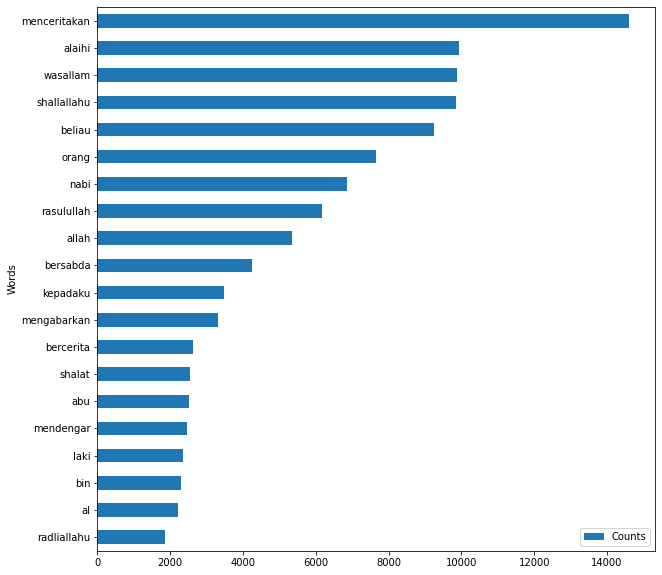

In [5]:
df_word_counts[:20].plot(kind='barh',figsize=(10,10),x='Words',y='Counts').invert_yaxis()

In [6]:
df_hadist_bukhari =pd.read_csv('../datasets/had_abudaud.csv',names=['L1','L2','Text'])

In [7]:
df_hadist_bukhari.Text

0       Telah menceritakan kepada kami [Abdullah bin M...
1       Telah menceritakan kepada kami [Musa bin Isma'...
2       Telah menceritakan kepada kami [Musaddad bin M...
3       Telah menceritakan kepada kami [Amru bin Marzu...
4       Telah menceritakan kepada kami [Abdullah bin M...
                              ...                        
4585    Telah menceritakan kepada kami [Musa bin Isma'...
4586    Telah menceritakan kepada kami [Musaddad] berk...
4587    Telah menceritakan kepada kami [Abdullah bin S...
4588    Telah menceritakan kepada kami [Muhammad bin I...
4589    Telah menceritakan kepada kami [Musa bin Isma'...
Name: Text, Length: 4590, dtype: object

## Model v1

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import re
import tqdm

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [10]:
global stopwords

def load_stopwords(file):
    return [line.rstrip('\n\r') for line in open(file)]

stopwords = load_stopwords('../data_label/stopwords/stopword_list_TALA.txt')

### preprocess data

In [11]:
def text_lower(text):
  return text.lower()

def remove_entities(text):
  return re.sub(r'\[[^]]*\]', '', text)

def case_folding(text):
  return re.sub(r'[^a-z]', ' ', re.sub("'", '', text))

def stemming(text):
  return stemmer.stem(text)

def stopwords_removal(texts):
  texts_token = texts.split()
  not_stopword = []
  for token in texts_token:
    if token not in stopwords:
      not_stopword.append(token)
  return ' '.join(not_stopword)

In [12]:
def preprocessing(text):
  tx_lower = text_lower(text)
  tx_remove_entities = remove_entities(tx_lower)
  tx_case_folding = case_folding(tx_remove_entities)
  tx_stemming = stemming(tx_case_folding)
  tx_stopword = stopwords_removal(tx_stemming)
  return tx_stopword

In [78]:
hadist_preprocessing = df_hadist_bukhari.Text.apply(preprocessing)

0    cerita cerita nabi shallallahu alaihi wasallam...
1    cerita cerita abar cerita tatkala abdullah bin...
Name: Text, dtype: object

In [119]:
hadist_preprocessing

0       cerita cerita nabi shallallahu alaihi wasallam...
1       cerita cerita abar cerita tatkala abdullah bin...
2       cerita cerita rasulullah shallallahu alaihi wa...
3       cerita abar rasulullah shallallahu alaihi wasa...
4       cerita cerita rasulullah shallallahu alaihi wa...
                              ...                        
4585    cerita cerita abar maksud abul husain khalid b...
4586    cerita cerita al aqra bin habis lihat nabi sha...
4587    cerita cerita masuk madinah aisyah anak baring...
4588    cerita cerita cerita kakek rombong utus abdu q...
4589    cerita cerita muawiyah pergi temu ibnu az zuba...
Name: Text, Length: 4590, dtype: object

In [76]:
hadist_preprocessing.to_csv('../trained/had_abudaud.csv')
    

## Load Model

In [168]:
hadist_df = pd.read_csv('../trained/had_abudaud.csv')

In [169]:
vectorizer = TfidfVectorizer()

In [170]:
X = vectorizer.fit_transform(hadist_df.Text)

In [171]:
vectorizer.get_feature_names()[:10]

['aabatil',
 'aabiduuna',
 'aadait',
 'aafinii',
 'aafiyata',
 'aafiyatika',
 'aaidzan',
 'aajili',
 'aajilihi',
 'aajirnii']

In [172]:
X.shape

(4590, 7471)

In [173]:
type(X)

scipy.sparse.csr.csr_matrix

In [174]:
X.toarray()[:,0].shape

(4590,)

In [175]:
vectorizer.get_feature_names().index('nikah')

4807

## Model Test

In [176]:
sentence = 'bagaimana cara bercerai ?'

In [177]:
sent_prep = preprocessing(sentence)

In [178]:
sent_prep

'cerai'

In [179]:
query = sent_prep.split()
res = np.zeros(X.shape[0])
not_in_corpus = []

for keyword in query:
    try:
        res += X.toarray()[:,vectorizer.get_feature_names().index(keyword)]
    except:
        not_in_corpus,append(keyword)
        res = np.zeros(X.shape[0])


In [180]:
not_in_corpus



[]

In [181]:
res

array([0., 0., 0., ..., 0., 0., 0.])

In [182]:
sum(res)

15.99952464084772

In [183]:
top_idx = np.argsort(-res)[:10]

In [184]:
top_idx

array([1340, 1391, 1336, 1812, 1337, 3819, 1346, 1334, 1347, 1335])

In [185]:
### get hadist
valid = False
if sum(res)>0:
    valid = True

if valid:
    for i in range(len(top_idx)):
        print(res[top_idx[i]], df_hadist_bukhari.iloc[top_idx[i]][2])
else:
    print('dindt match, someting wrong')

0.7479361991822463 Telah menceritakan kepada kami [Bisyr bin Hilal], bahwa [Ja'far Sulaiman], ia telah menceritakan kepada mereka dari [Yazid Ar Risyk], dari [Mutharrif bin Abdullah], bahwa [Imran bin Hushain] ditanya mengenai seorang laki-laki yang mencerai isterinya kemudian menggaulinya dan tidak mempersaksikan perceraiannya dan tidak pula pencabutan perceraiannya. Ia berkata; engkau mencerai tidak secara sunah dan kembali tidak secara sunah. Persaksikan atas perceraiannya dan ruju' (kembali kapadanya), dan jangan engkau ulang hal itu lagi! 
0.6854545489891136 Telah menceritakan kepada kami [Sulaiman bin Abdul Hamid Al Bahrani], telah menceritakan kepada kami [Yahya bin Shalih], telah menceritakan kepada kami [Isma'il bin 'Ayyasy], telah menceritakan kepadaku ['Amr bin Muhajir] dari [ayahnya] dari [Asma` binti Yazid bin As Sakan Al Anshariyyah] bahwa ia telah dicerai pada zaman Rasulullah shallallahu 'alaihi wasallam dan wanita yang dicerai tidak memiliki 'iddah, kemudian Allah 'azz